In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mandelbrot.mandelbrot_functions import mandelbrot_dataset_creator, plot_mandelbrot_dataset

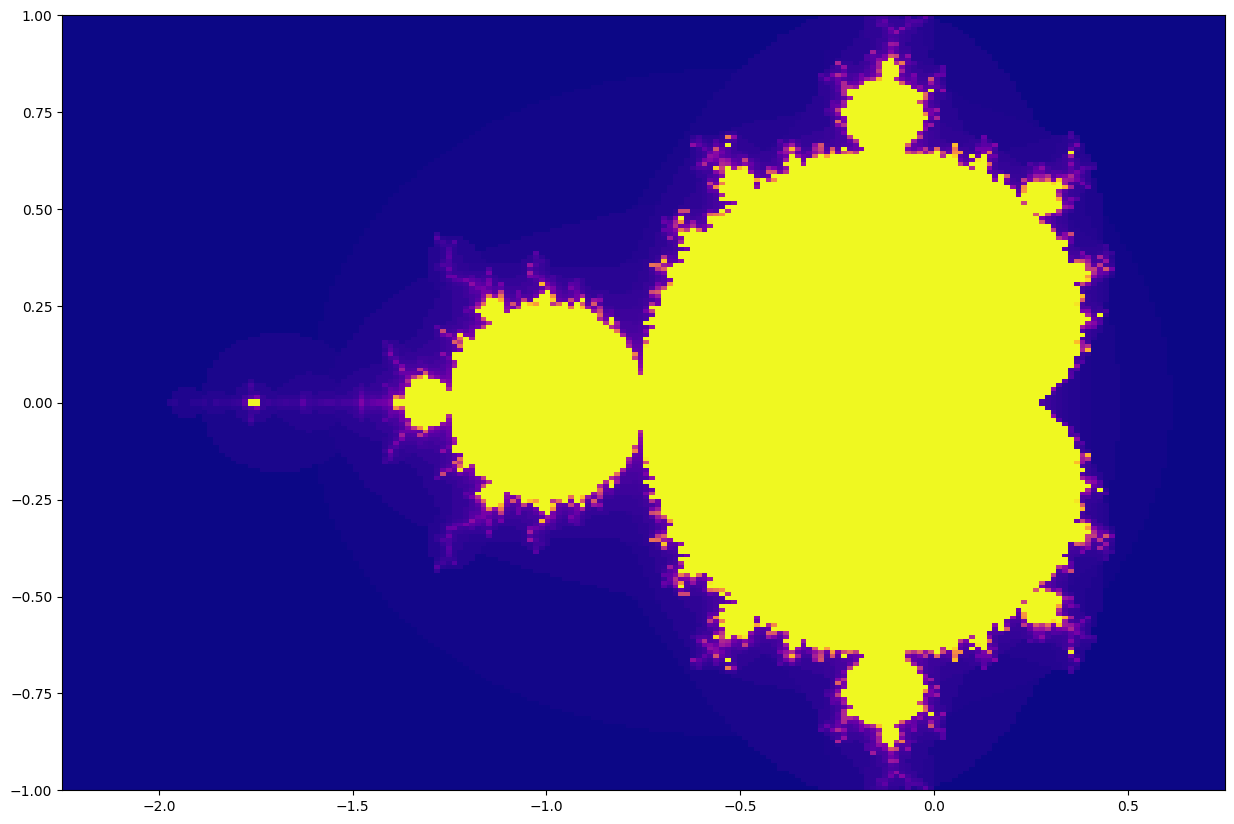

In [3]:
#test out full functionality (default values)
dataset = mandelbrot_dataset_creator(classification_threshold=1)
plot_mandelbrot_dataset(dataset)

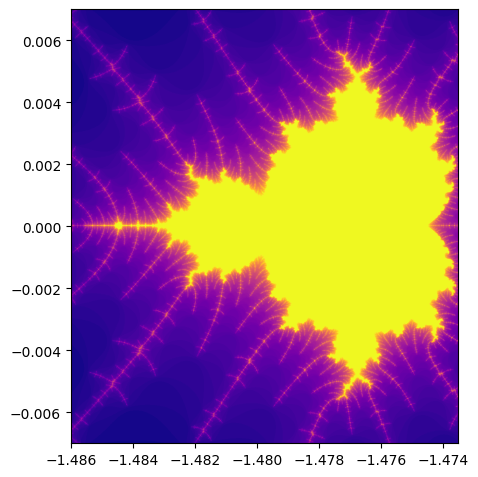

In [4]:
#test out full adjustable functionality (keyword args)
dataset = mandelbrot_dataset_creator(real_start = -1.486, 
                                     real_end = -1.4735, 
                                     real_nr_pixels = 1000, 
                                     imag_start = -0.007j, 
                                     imag_end = 0.007j, 
                                     imag_nr_pixels = 2000,
                                     initial_z = 0, 
                                     exponent = 2,
                                     nr_iterations = 100,
                                     classification_threshold = 2)

plot_mandelbrot_dataset(dataset, fig_size = (5,10), show_color_bar = False)

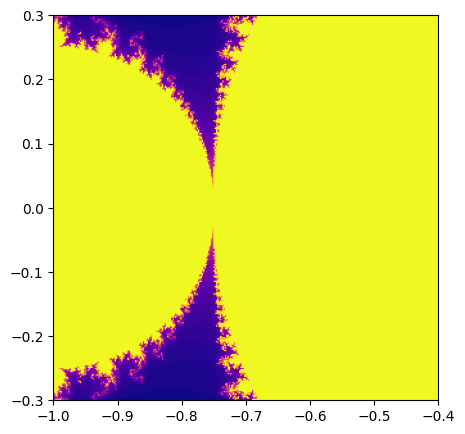

In [5]:
#test out full adjustable functionality (keyword args)
dataset = mandelbrot_dataset_creator(real_start = -1, 
                                  real_end = -0.4, 
                                  real_nr_pixels = 300, 
                                  imag_start = -0.3j, 
                                  imag_end = 0.3j, 
                                  imag_nr_pixels = 300,
                                  initial_z = 0, 
                                  exponent = 2,
                                  nr_iterations = 100)

plot_mandelbrot_dataset(dataset, fig_size = (5,5))

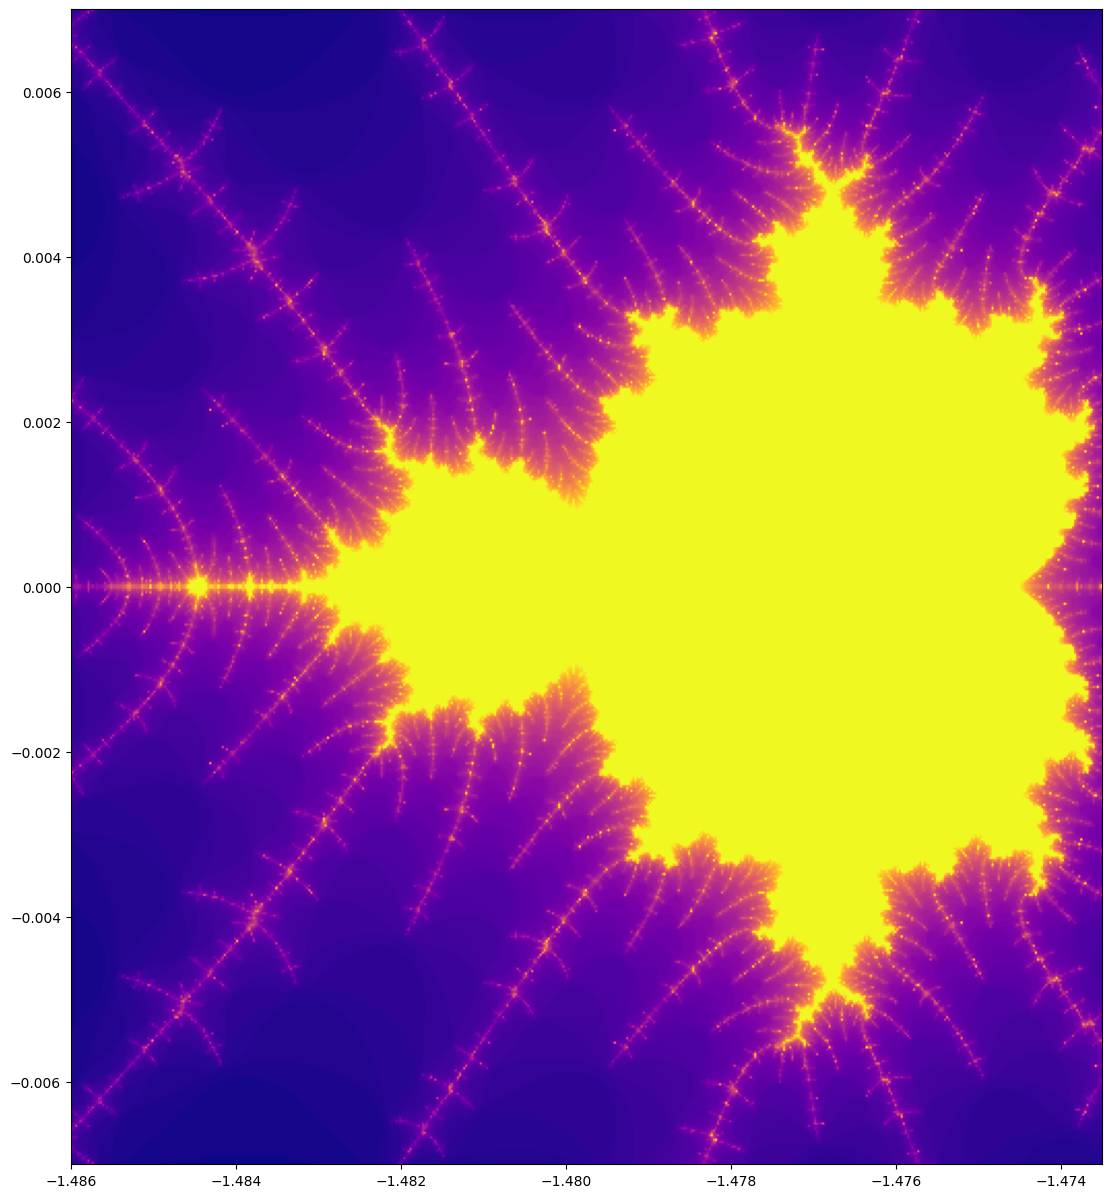

In [6]:
"""Calculate raw data points"""

#Get raw data points 
df = mandelbrot_dataset_creator(real_start = -1.486, 
                                real_end = -1.4735, 
                                real_nr_pixels = 500, 
                                imag_start = -0.007j, 
                                imag_end = 0.007j, 
                                imag_nr_pixels = 500,
                                initial_z = 0, 
                                exponent = 2,
                                nr_iterations = 100,
                                classification_threshold = 2)

#get dimension for later usage
c_real = np.float64(df.columns)
c_imag = df.index

#transpose/ transform data from shape (1000, 1000) -> (1000000, 3)
data = pd.melt(df.reset_index(), id_vars= "index", value_vars=df.columns[1:]).astype({"variable": float})

plot_mandelbrot_dataset(df)

In [7]:
#rename columns and inspect data
data.columns = ["imag_part", "real_part", "diverges_at_iter"]

print(f"Data is {round(data.memory_usage(deep=True).sum() / (1024 ** 2))} Megabytes big")
data.head(20)

Data is 6 Megabytes big


,imag_part,real_part,diverges_at_iter
0,-0.007000,-1.485975,23
1,-0.006972,-1.485975,24
2,-0.006944,-1.485975,25
3,-0.006916,-1.485975,25
4,-0.006888,-1.485975,27
5,-0.006860,-1.485975,29
6,-0.006832,-1.485975,33
7,-0.006804,-1.485975,30
8,-0.006776,-1.485975,28
9,-0.006747,-1.485975,28


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

"""Prepare raw data for DL Model"""

#create features, targets
X = data[["real_part", "imag_part"]]
y = data[["diverges_at_iter"]]

#create preprocessor pipe
#X_preprocessor_pipe = make_pipeline(MinMaxScaler(), PolynomialFeatures(degree=2), MinMaxScaler())
y_preprocessor_pipe = make_pipeline(MinMaxScaler())
X_preprocessor_pipe = make_pipeline(MinMaxScaler())

#standardscale all data 
X_trans = X_preprocessor_pipe.fit_transform(X)
y_trans = y_preprocessor_pipe.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_trans, y_trans)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(187125, 2) (62375, 2) (187125, 1) (62375, 1)


In [9]:
from mandelbrot.mandelbrot_functions import initialize_model

model = initialize_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                96        
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3297 (12.88 KB)
Trainable params: 3297 (12.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras.models import Sequential

"""train neural network"""

#create custom callback storing model at each epoch
class ModelCheckpointList(Callback):
    def __init__(self):
        super(ModelCheckpointList, self).__init__()
        self.models = []

    def on_epoch_end(self, epoch, logs=None):
        # Save the model's architecture and weights
        config = self.model.get_config()
        weights = self.model.get_weights()

        # Recreate a new model from the architecture and weights
        new_model = Sequential.from_config(config)
        new_model.set_weights(weights)

        # Append the model to the list
        self.models.append(new_model)

#init model
model = initialize_model()

#define callbacks
early_stopping = EarlyStopping(patience = 20, monitor = "val_loss", restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience = 10, min_lr=0.00001)
checkpoint_list_callback = ModelCheckpointList()

#train model (always with ca. batch_size = 1000)
history = model.fit(
    X_train,
    y_train,
    validation_split = 0.2,
    batch_size = 32,
    epochs = 100,
    callbacks = [early_stopping, reduce_lr, checkpoint_list_callback])

Epoch 1/100
4679/4679 [==============================] - 3s 675us/step - loss: 0.0194 - mae: 0.0838 - val_loss: 0.0128 - val_mae: 0.0620 - lr: 0.0010
Epoch 2/100
4679/4679 [==============================] - 3s 631us/step - loss: 0.0104 - mae: 0.0578 - val_loss: 0.0121 - val_mae: 0.0671 - lr: 0.0010
Epoch 3/100
4679/4679 [==============================] - 3s 618us/step - loss: 0.0092 - mae: 0.0532 - val_loss: 0.0080 - val_mae: 0.0488 - lr: 0.0010
Epoch 4/100
4679/4679 [==============================] - 3s 669us/step - loss: 0.0082 - mae: 0.0495 - val_loss: 0.0075 - val_mae: 0.0473 - lr: 0.0010
Epoch 5/100
4679/4679 [==============================] - 3s 649us/step - loss: 0.0076 - mae: 0.0471 - val_loss: 0.0071 - val_mae: 0.0467 - lr: 0.0010
Epoch 6/100
4679/4679 [==============================] - 3s 655us/step - loss: 0.0073 - mae: 0.0458 - val_loss: 0.0076 - val_mae: 0.0460 - lr: 0.0010
Epoch 7/100
4679/4679 [==============================] - 3s 669us/step - loss: 0.0069 - mae: 0.0440 

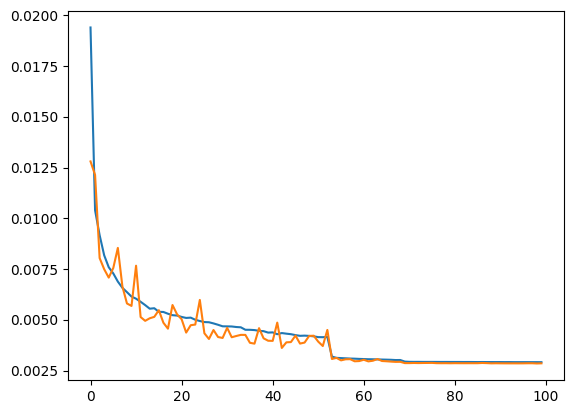

In [11]:
#plot loss and val los
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [12]:
#get predicitons for each pixel in original grid from final model
predictions = model.predict(X_trans, batch_size=int(len(X_train) / 100))
predictions



134/134 [==============================] - 0s 804us/step


array([[0.0768257 ],
       [0.08221404],
       [0.08794428],
       ...,
       [0.05671807],
       [0.05456275],
       [0.05248454]], dtype=float32)

In [13]:
#inverse transform predicitions
predictions = y_preprocessor_pipe.inverse_transform(predictions)
predictions

array([[24.222881],
       [24.659338],
       [25.123487],
       ...,
       [22.594164],
       [22.419584],
       [22.251247]], dtype=float32)

In [14]:
#load predictions into df and convert to grid 
prediciton_df = pd.DataFrame({"real_part" : X["real_part"], "imag_part" : X["imag_part"], "prediction" : predictions[:,0]})
prediciton_df = prediciton_df.pivot(index = "imag_part", columns = "real_part", values = "prediction")
prediciton_df.head(10)

real_part,-1.485975,-1.485950,-1.485925,-1.485900,-1.485875,-1.485850,-1.485825,-1.485800,-1.485775,-1.485749,...,-1.473725,-1.473700,-1.473675,-1.473650,-1.473625,-1.473600,-1.473575,-1.473550,-1.473525,-1.473500
imag_part,,,,,,,,,,,,,,,,,,,,,
-0.007000,24.222881,23.797300,23.398731,23.025728,22.740999,22.597292,22.457699,22.303968,22.135866,21.973982,...,21.075621,21.047937,21.020487,20.993277,20.966303,20.939564,20.913055,20.886774,20.860727,20.834904
-0.006972,24.659338,24.206377,23.781843,23.384260,23.012190,22.749542,22.605614,22.465788,22.298386,22.130478,...,21.138521,21.110291,21.082304,21.054560,21.027056,20.999786,20.972757,20.945959,20.919394,20.893064
-0.006944,25.123487,24.641779,24.189932,23.766436,23.369833,22.998692,22.758127,22.613947,22.466923,22.292801,...,21.200020,21.171392,21.143009,21.114870,21.086967,21.059313,21.031891,21.004707,20.978533,20.952700
-0.006916,25.616667,25.104843,24.624277,24.173519,23.751053,23.355442,22.985226,22.766716,22.622301,22.461126,...,21.258644,21.229515,21.200630,21.171993,21.143606,21.115458,21.088383,21.061634,21.035103,21.008801
-0.006888,26.140230,25.596859,25.086218,24.606810,24.157139,23.735710,23.341076,22.971796,22.775326,22.630663,...,21.318300,21.288654,21.259264,21.230127,21.202112,21.174417,21.146955,21.119717,21.098970,21.088848
-0.006860,26.695517,26.119198,25.577085,25.067646,24.589392,24.140802,23.720411,23.326748,22.966166,22.783957,...,21.378996,21.348835,21.319859,21.291189,21.262754,21.234556,21.206593,21.196167,21.207253,21.218374
-0.006832,27.283859,26.673223,26.098238,25.557360,25.049110,24.572002,24.124498,23.705141,23.312466,22.968653,...,21.441740,21.412062,21.382629,21.353441,21.324493,21.320585,21.332079,21.343618,21.355188,21.366800
-0.006804,27.906559,27.260263,26.650982,26.077288,25.537672,25.030634,24.554659,24.108246,23.689924,23.298208,...,21.500229,21.473764,21.453598,21.449621,21.461544,21.473511,21.485518,21.497559,21.509642,21.521763
-0.006776,28.564863,27.881594,27.236704,26.628805,26.056404,25.518051,25.012190,24.537367,24.092031,23.674725,...,21.574636,21.571480,21.582582,21.598770,21.615023,21.631353,21.645685,21.658258,21.670868,21.683525


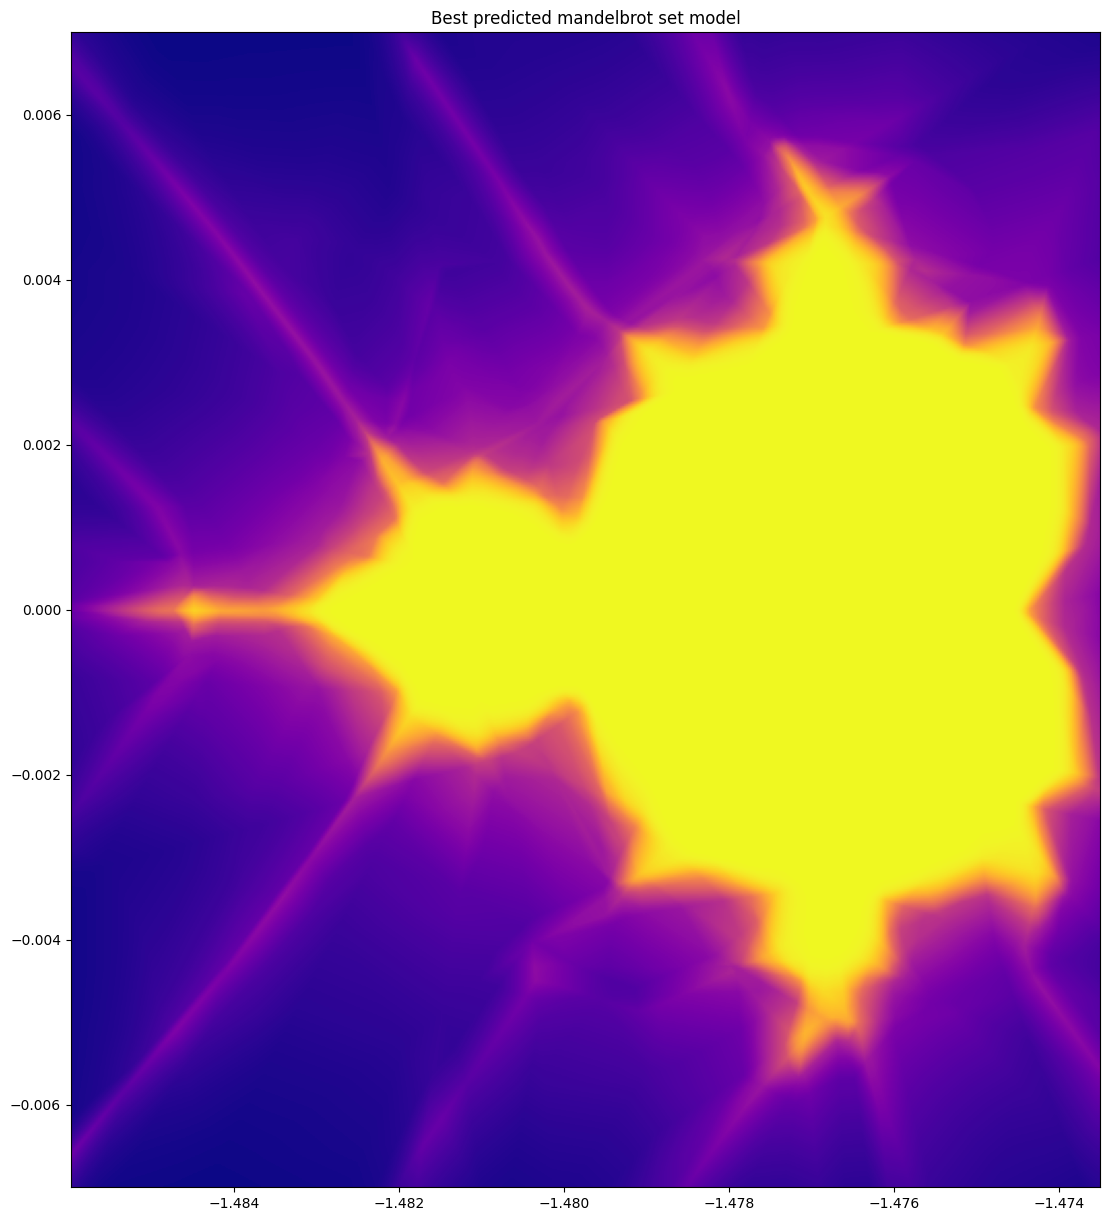

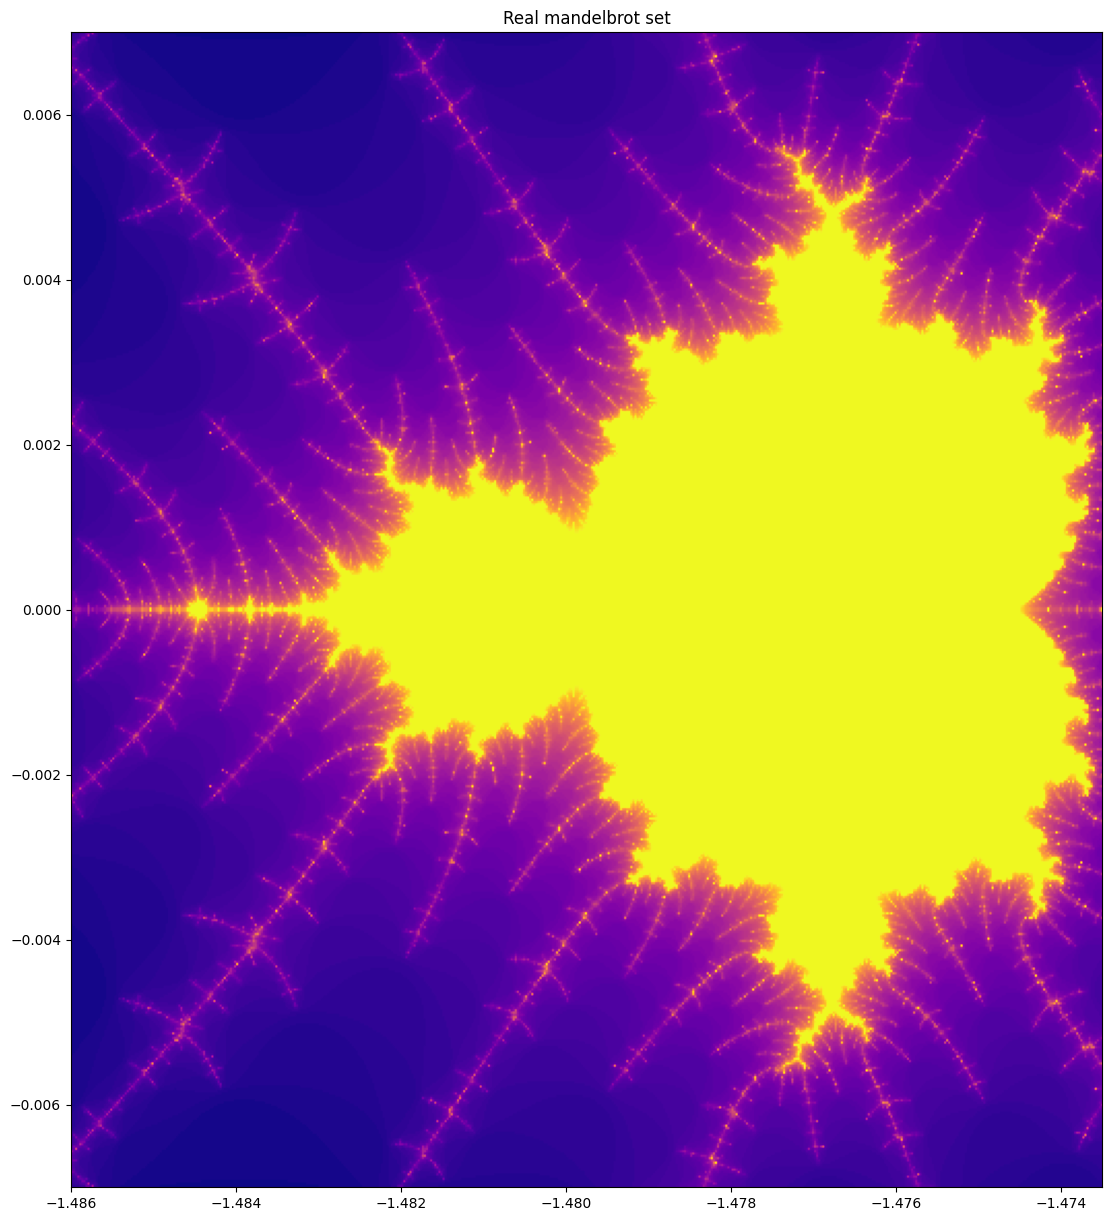

In [15]:
#plot predictions vs real values
plot_mandelbrot_dataset(prediciton_df, fig_size = (15,15), title = "Best predicted mandelbrot set model")
plot_mandelbrot_dataset(df, fig_size = (15,15), title = "Real mandelbrot set")


In [16]:
X_trans

array([[0.        , 0.        ],
       [0.        , 0.00200401],
       [0.        , 0.00400802],
       ...,
       [1.        , 0.99599198],
       [1.        , 0.99799599],
       [1.        , 1.        ]])

In [17]:
import ipywidgets as widgets

"""create predictions for each of the saved (via custom callback) models after each epoch"""

#step size between epochs
step_size = 1

#init results df, that will contain predictions per model
prediction_dfs = []

#iterate over each model in each epoch
for epoch in range(0, len(checkpoint_list_callback.models), step_size):

    #get model at epoch 
    model = checkpoint_list_callback.models[epoch]
    
    #calc predicitons
    predictions = model.predict(X_trans, verbose=1, batch_size = int(len(X_train) / 1000))

    #detransform predicitions
    predictions = y_preprocessor_pipe.inverse_transform(predictions)

    #load predictions into df and convert to grid 
    prediction_df = pd.DataFrame({"real_part" : X["real_part"], "imag_part" : X["imag_part"], "prediction" : predictions[:,0]})
    prediction_df = prediction_df.pivot(index = "imag_part", columns = "real_part", values = "prediction")
    prediction_df.head(10)

    #save result
    prediction_dfs.append(prediction_df)

1335/1335 [==============================] - 1s 375us/step


In [20]:
from IPython.display import clear_output

clear_output(wait=True)

#Function to display the image given an index
def plot_image(i=0):
    plot_mandelbrot_dataset(prediction_dfs[i])
    
#Create an interactive slider
widgets.interactive(plot_image, i=(0, len(prediction_dfs) - 1))

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…